In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import warnings
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.dates as mdates
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import pickle

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
# Cell 2: Load the data from CSV
# Define the path to your CSV file
csv_file_path = "C:/Users/User/Downloads/UMHackathon2025/data/cryptoquant_btc-exchange-flows-in-house-flow_window_block&exchange_all_exchange.csv"

print(f"Reading data from CSV file: {csv_file_path}")

Reading data from CSV file: C:/Users/User/Downloads/UMHackathon2025/data/cryptoquant_btc-exchange-flows-in-house-flow_window_block&exchange_all_exchange.csv


In [3]:
# Cell 3: Process the CSV data
try:
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    print("Successfully loaded CSV data")
    print("Data shape:", df.shape)
    print("Columns:", df.columns.tolist())
    
    # Convert timestamp column to datetime if it exists
    if 'ts' in df.columns:
        df['datetime'] = pd.to_datetime(df['ts'], unit='ms')
    elif 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    else:
        # Try to identify a timestamp column by looking for columns with large integer values
        potential_ts_cols = []
        for col in df.columns:
            if df[col].dtype in ['int64', 'float64']:
                # Check if values are in millisecond range (2000s to 2030)
                if df[col].min() > 946684800000 and df[col].max() < 1893456000000:  # 2000-01-01 to 2030-01-01
                    potential_ts_cols.append(col)
        
        if potential_ts_cols:
            print(f"Found potential timestamp columns: {potential_ts_cols}")
            df['datetime'] = pd.to_datetime(df[potential_ts_cols[0]], unit='ms')
        else:
            print("Warning: No timestamp column identified. Creating a synthetic datetime index.")
            df['datetime'] = pd.date_range(start=datetime.now() - timedelta(days=len(df)), periods=len(df))
    
    print("First few rows:")
    print(df.head())
    
except Exception as e:
    print(f"Error loading CSV file: {e}")
    print("Falling back to synthetic data for demonstration")
    
    # Function to generate synthetic data as a fallback
    def generate_synthetic_data(n_samples=1000):
        # Create date range for the past n_samples days
        end_date = datetime.now()
        start_date = end_date - timedelta(days=n_samples)
        date_range = pd.date_range(start=start_date, end=end_date, periods=n_samples)
        
        # Create blockheight (approximately 144 blocks per day in Bitcoin)
        start_block = 700000  # Approximate block height from 2022
        blockheights = np.arange(start_block, start_block + n_samples * 144, 144)
        
        # Create flow data with some realistic patterns
        # Add regime shifts to demonstrate HMM capabilities
        np.random.seed(42)
        
        # Create two distinct regimes
        regime_1 = np.random.normal(100, 30, size=n_samples//2)  # Normal flow regime
        regime_2 = np.random.normal(300, 80, size=n_samples//2)  # High flow regime
        
        # Add some transitions and noise
        flow_total = np.concatenate([regime_1, regime_2])
        # Add random spikes and dips
        flow_total = flow_total + np.random.exponential(50, size=n_samples) * np.random.choice([-1, 1], size=n_samples)
        
        # Generate correlated but different flow_mean
        flow_mean = flow_total / np.random.uniform(10, 30, size=n_samples)
        
        # Generate transactions count with correlation to flow_total
        transactions_count = flow_total * np.random.uniform(0.5, 2, size=n_samples) + np.random.normal(500, 100, size=n_samples)
        transactions_count = transactions_count.astype(int)
        
        # Create a dataframe
        df = pd.DataFrame({
            'ts': date_range.astype(np.int64) // 10**6,  # Unix timestamp in milliseconds
            'blockheight': blockheights,
            'datetime': date_range,
            'flow_mean': flow_mean,
            'flow_total': flow_total,
            'transactions_count_flow': transactions_count
        })
        
        return df
    
    # Generate synthetic data
    df = generate_synthetic_data(1000)
    print("Using synthetic data for demonstration")

Successfully loaded CSV data
Data shape: (53185, 6)
Columns: ['start_time', 'blockheight', 'datetime', 'flow_mean', 'flow_total', 'transactions_count_flow']
Found potential timestamp columns: ['start_time']
First few rows:
      start_time  blockheight            datetime  flow_mean    flow_total  \
0  1712655185000       838429 2024-04-09 09:33:05  95.027511  10928.163749   
1  1712655421000       838430 2024-04-09 09:37:01  16.960356    627.533158   
2  1712656842000       838431 2024-04-09 10:00:42   5.009741    566.100779   
3  1712657493000       838432 2024-04-09 10:11:33  23.270747   1279.891070   
4  1712658124000       838433 2024-04-09 10:22:04  13.106378    655.318880   

   transactions_count_flow  
0                      115  
1                       37  
2                      113  
3                       55  
4                       50  


In [4]:
# Cell 4: Display data statistics and find features
# Display basic statistics
print("\nBasic statistics:")
df.describe()


Basic statistics:


,start_time,blockheight,datetime,flow_mean,flow_total,transactions_count_flow
count,5.318500e+04,53185.00000,53185,53185.000000,53185.000000,53185.000000
mean,1.728493e+12,865021.00000,2024-10-09 16:49:49.819366400,20.032958,874.740020,41.937106
min,1.712655e+12,838429.00000,2024-04-09 09:33:05,0.000000,0.000000,0.000000
25%,1.720727e+12,851725.00000,2024-07-11 19:39:33,4.470943,96.214313,17.000000
50%,1.728556e+12,865021.00000,2024-10-10 10:34:36,9.002710,322.429798,34.000000
75%,1.736318e+12,878317.00000,2025-01-08 06:36:28,20.642046,1013.621234,58.000000
max,1.744188e+12,891613.00000,2025-04-09 08:38:23,4447.247543,182936.424738,880.000000
std,9.086239e+09,15353.33137,NaN,62.679794,2280.700498,34.233341


In [9]:
# Cell 5: Identify feature columns
# Identify feature columns
expected_features = ['flow_mean', 'flow_total', 'transactions_count_flow']
available_features = []

for feature in expected_features:
    if feature in df.columns:
        available_features.append(feature)
    else:
        # Look for similar column names
        for col in df.columns:
            if feature.lower() in col.lower():
                available_features.append(col)
                print(f"Using '{col}' as a substitute for '{feature}'")
                break

# If we still don't have enough features, select some numeric columns
if len(available_features) < 3:
    print("Warning: Not all expected features are available in the dataset.")
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    # Exclude blockheight, timestamp columns
    feature_candidates = [col for col in numeric_cols if 'block' not in col.lower() and 'time' not in col.lower() and 'ts' != col]
    
    # Add additional features as needed
    for col in feature_candidates:
        if col not in available_features and len(available_features) < 3:
            available_features.append(col)
            print(f"Adding '{col}' as an additional feature")

features = available_features
print(f"\nUsing features: {features}")


Using features: ['flow_mean', 'flow_total', 'transactions_count_flow']


In [10]:
# Cell 6: Prepare data for analysis
# Sort by datetime to ensure chronological order
df = df.sort_values('datetime').reset_index(drop=True)

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Fill any missing values with appropriate methods
df = df.fillna(method='ffill')


Missing values in each column:
start_time                 0
blockheight                0
datetime                   0
flow_mean                  0
flow_total                 0
transactions_count_flow    0
dtype: int64


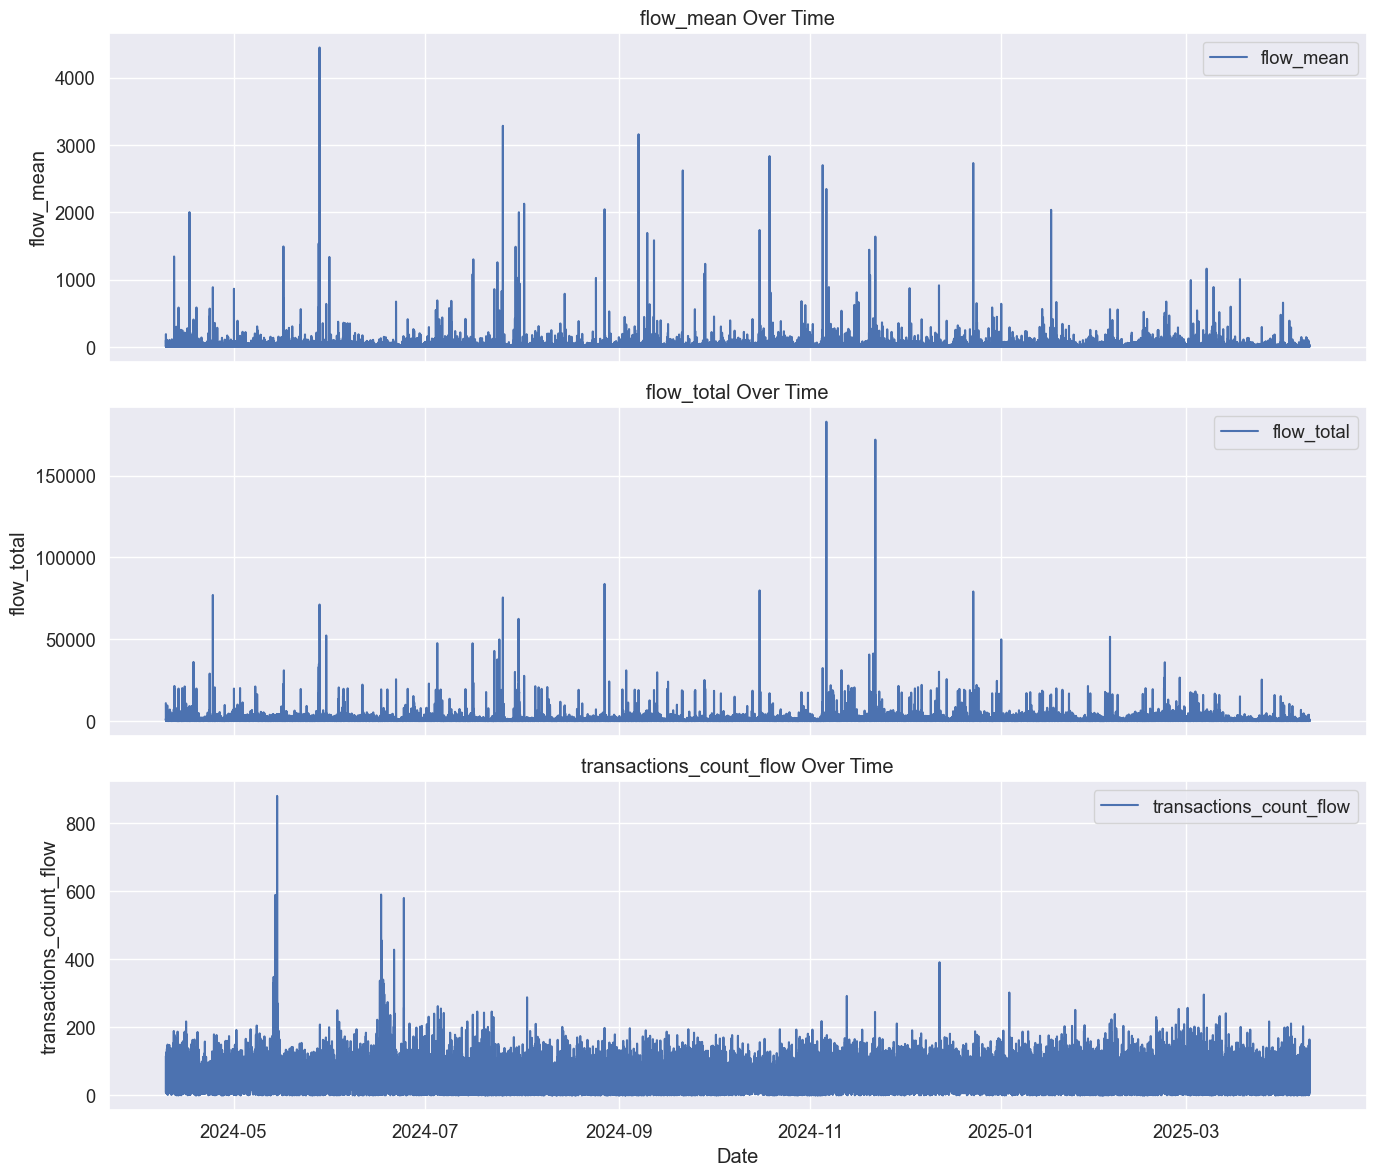

In [11]:
# Cell 7: Plot time series data
# Plot the time series data
fig, axes = plt.subplots(len(features), 1, figsize=(14, 4*len(features)), sharex=True)

# Handle case where there's only one feature
if len(features) == 1:
    axes = [axes]

for i, feature in enumerate(features):
    axes[i].plot(df['datetime'], df[feature], label=feature)
    axes[i].set_title(f'{feature} Over Time')
    axes[i].set_ylabel(feature)
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [12]:
# Cell 8: Prepare features and standardize
# Feature selection and standardization
X = df[features].copy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with the scaled features for easier manipulation
X_df = pd.DataFrame(X_scaled, columns=features, index=df.index)


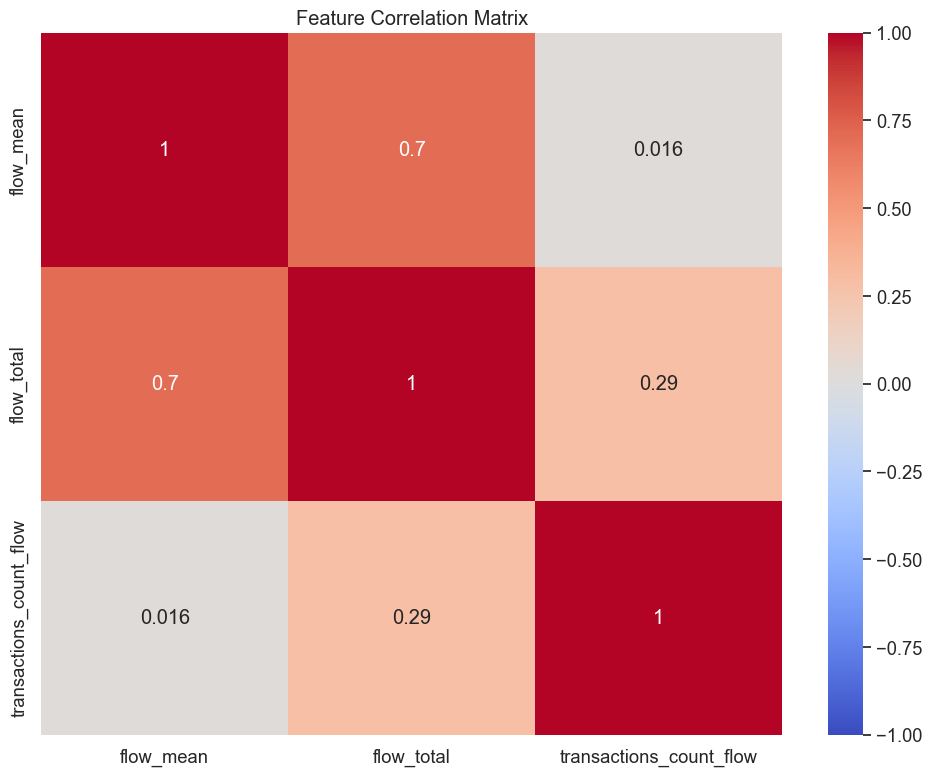

In [13]:
# Cell 9: Plot feature correlations
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

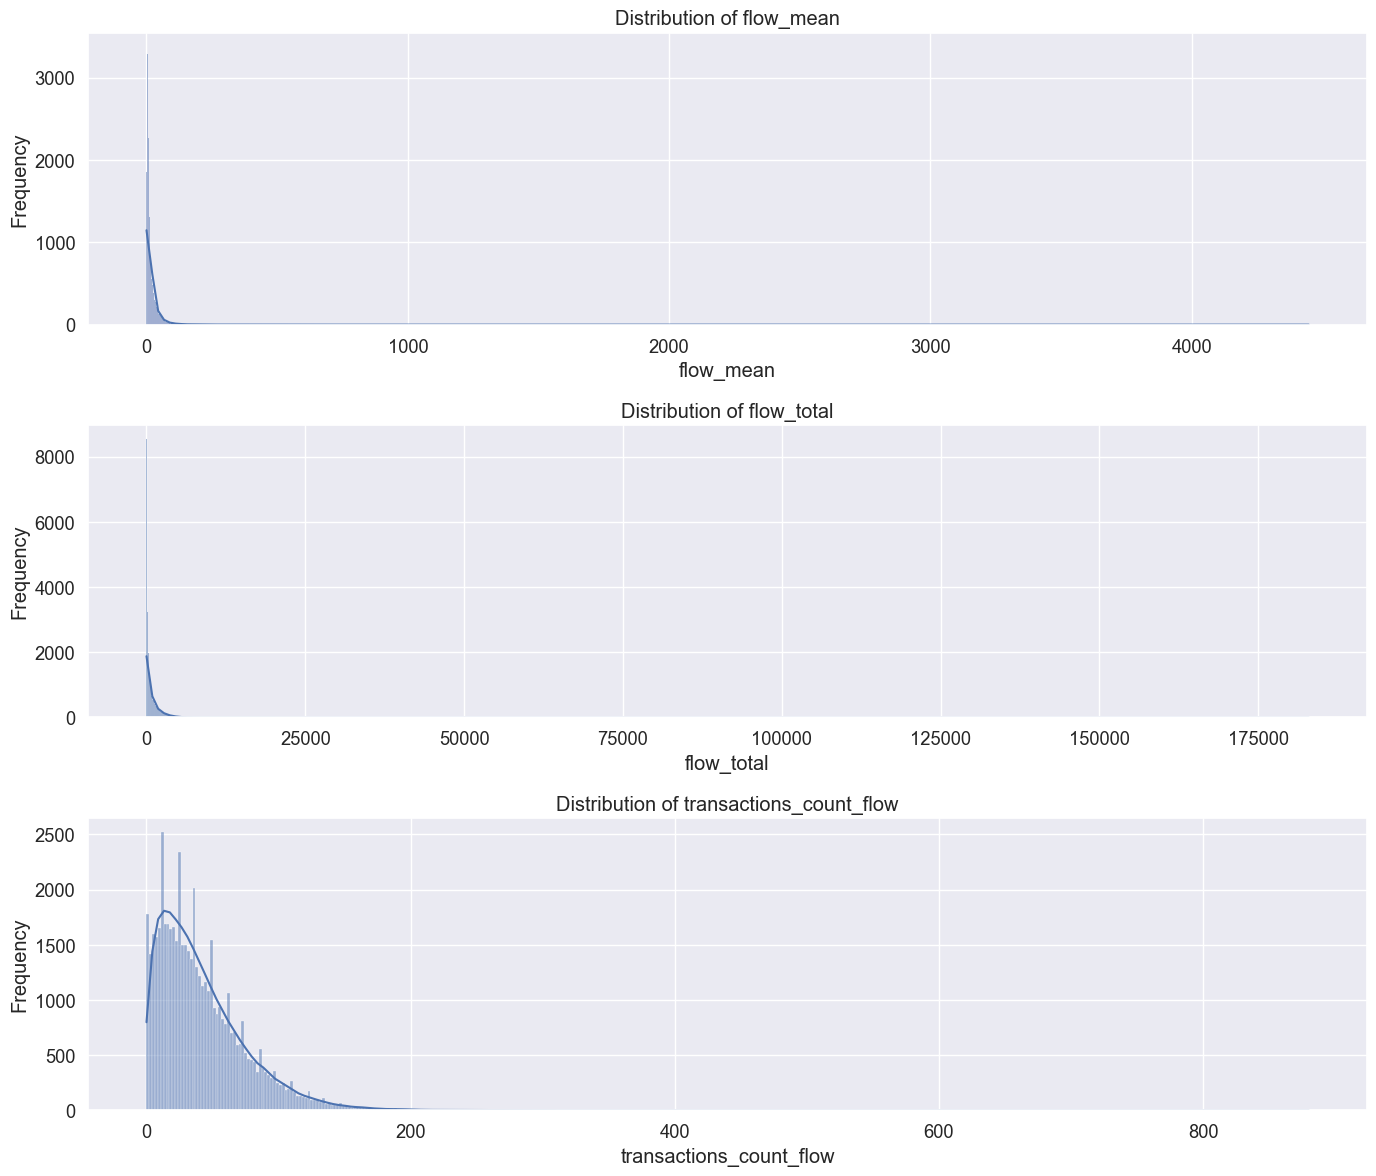

In [14]:
# Cell 10: Plot feature distributions
# Distribution of features
fig, axes = plt.subplots(len(features), 1, figsize=(14, 4*len(features)), sharex=False)

# Handle case where there's only one feature
if len(features) == 1:
    axes = [axes]

for i, feature in enumerate(features):
    sns.histplot(X[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [15]:
# Cell 11: Define function to find optimal number of states
def find_optimal_states(X_scaled, max_states=10):
    n_states_range = range(2, max_states + 1)
    bic_scores = []
    aic_scores = []
    silhouette_scores = []
    
    for n_states in n_states_range:
        print(f"Testing model with {n_states} states...")
        # Initialize and fit the model
        model = hmm.GaussianHMM(n_components=n_states, covariance_type='full', 
                               n_iter=100, random_state=42)
        model.fit(X_scaled)
        
        # Calculate BIC and AIC
        n_features = X_scaled.shape[1]
        n_params = n_states * n_states + n_states * n_features + n_states * n_features * (n_features + 1) // 2
        log_likelihood = model.score(X_scaled)
        bic = -2 * log_likelihood + n_params * np.log(X_scaled.shape[0])
        aic = -2 * log_likelihood + 2 * n_params
        
        bic_scores.append(bic)
        aic_scores.append(aic)
        
        # Decode the states
        hidden_states = model.predict(X_scaled)
        
        # Calculate silhouette score only if we have more than one state
        if n_states > 1:
            try:
                silhouette = silhouette_score(X_scaled, hidden_states)
                silhouette_scores.append(silhouette)
            except:
                silhouette_scores.append(np.nan)
        else:
            silhouette_scores.append(np.nan)
    
    # Plot the BIC and AIC scores
    plt.figure(figsize=(12, 8))
    plt.plot(n_states_range, bic_scores, 'o-', label='BIC')
    plt.plot(n_states_range, aic_scores, 's-', label='AIC')
    plt.xlabel('Number of States')
    plt.ylabel('Score')
    plt.title('BIC and AIC Scores for Different Numbers of States')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot silhouette scores
    plt.figure(figsize=(12, 8))
    plt.plot(n_states_range, silhouette_scores, 'o-', label='Silhouette Score')
    plt.xlabel('Number of States')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Numbers of States')
    plt.grid(True)
    plt.show()
    
    # Find the optimal number of states based on lowest BIC
    optimal_n_states = n_states_range[np.argmin(bic_scores)]
    print(f"Optimal number of states based on BIC: {optimal_n_states}")
    
    return optimal_n_states


Testing model with 2 states...
Testing model with 3 states...
Testing model with 4 states...
Testing model with 5 states...
Testing model with 6 states...


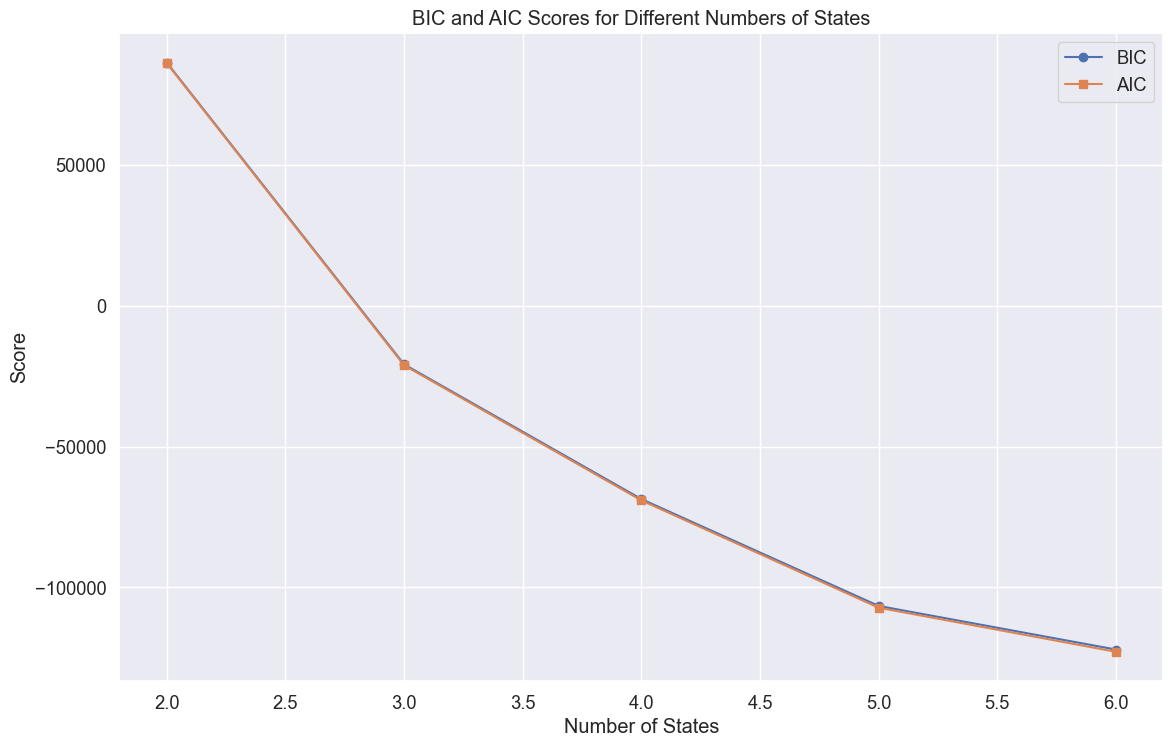

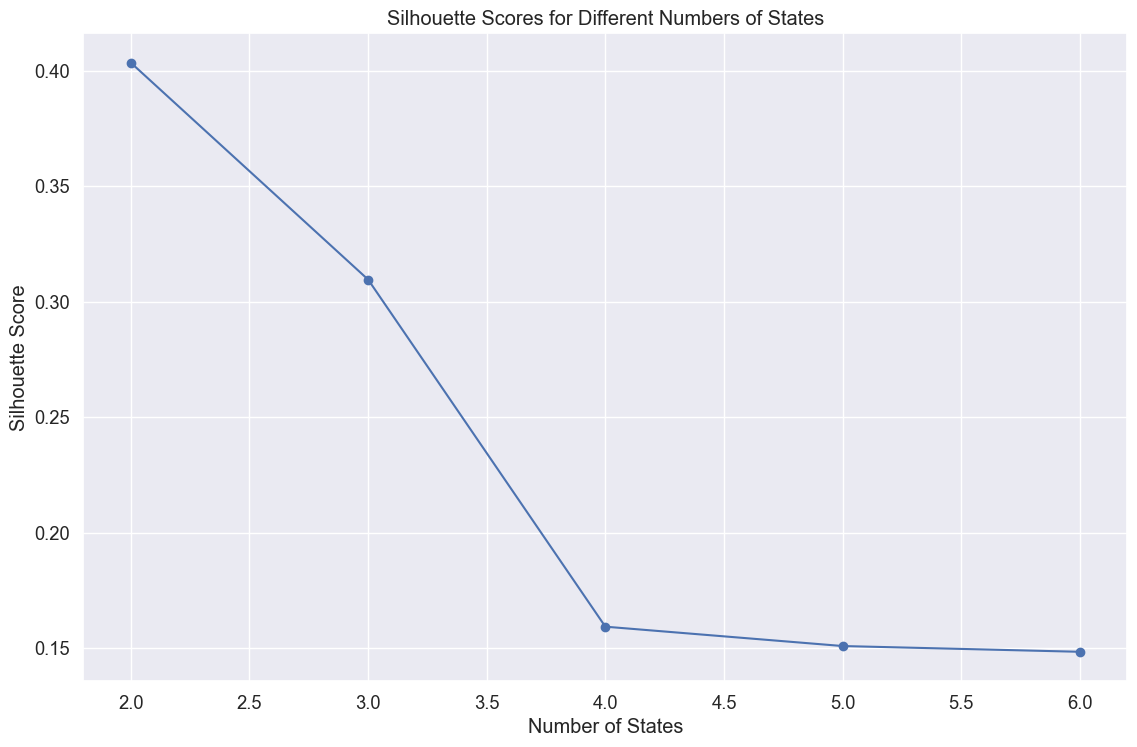

Optimal number of states based on BIC: 6


In [16]:
# Cell 12: Find optimal number of states
# Find optimal number of states
optimal_n_states = find_optimal_states(X_scaled, max_states=6)

In [17]:
# Cell 13: Create and fit the HMM model
# Create and fit the HMM model
model = hmm.GaussianHMM(n_components=optimal_n_states, 
                       covariance_type='full', 
                       n_iter=100, 
                       random_state=42)

model.fit(X_scaled)

# Predict the hidden states (regimes)
hidden_states = model.predict(X_scaled)

# Add the hidden states to the original dataframe
df['regime'] = hidden_states

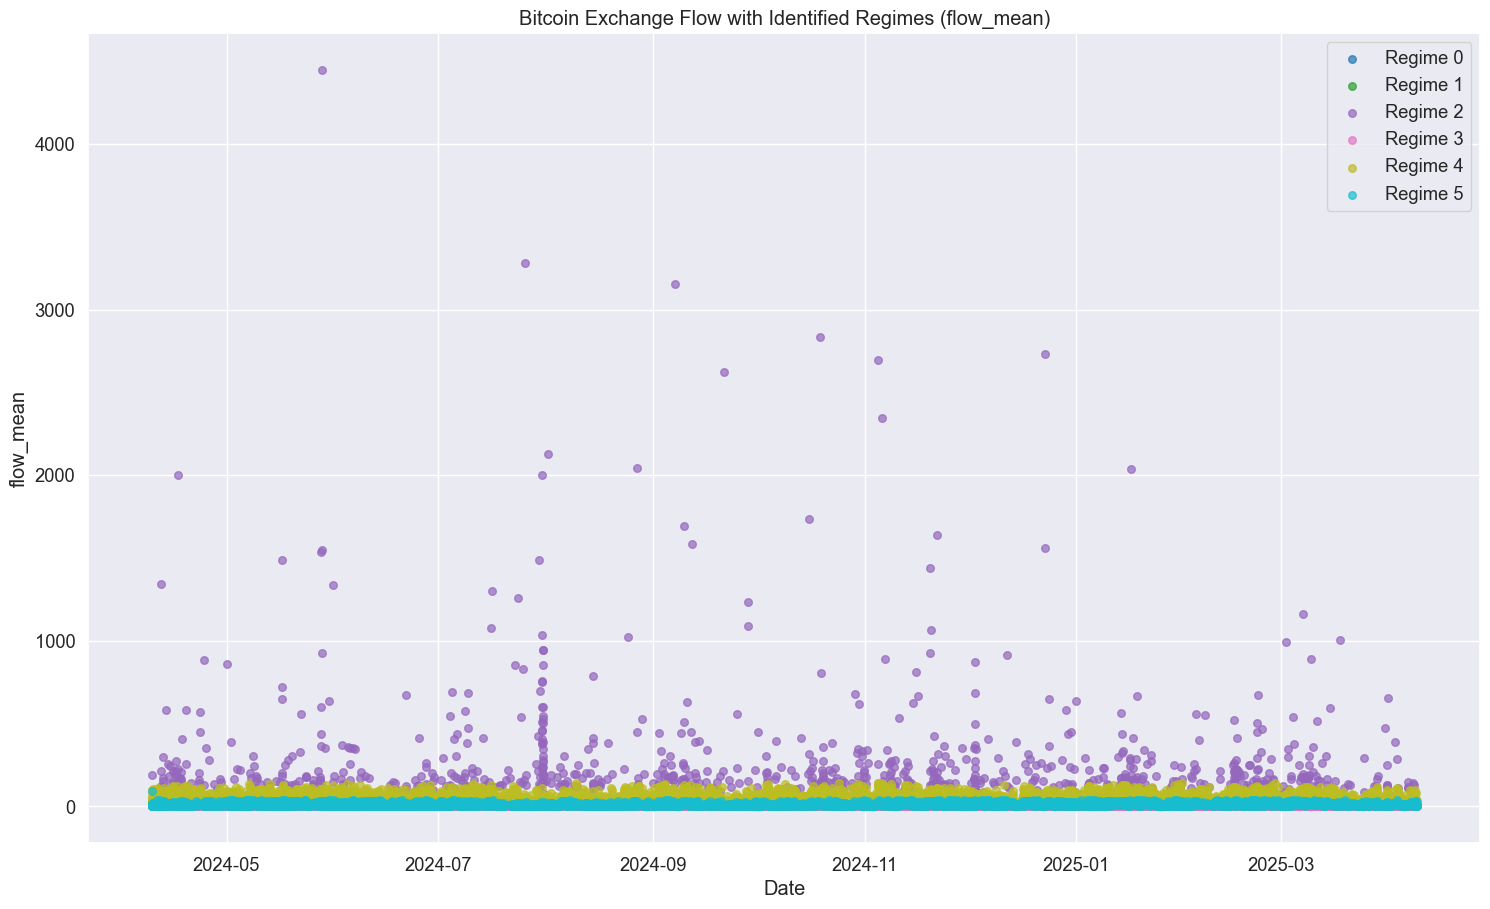

In [18]:
# Cell 14: Visualize the identified regimes
# Visualize the regimes
plt.figure(figsize=(16, 10))

# Create a colormap for the regimes
colors = plt.cm.tab10(np.linspace(0, 1, optimal_n_states))

# Plot the time series with points colored by regime
for state in range(optimal_n_states):
    mask = (df['regime'] == state)
    plt.scatter(df.loc[mask, 'datetime'], 
                df.loc[mask, features[0]], 
                c=[colors[state]], 
                label=f'Regime {state}',
                alpha=0.7,
                s=30)

plt.title(f'Bitcoin Exchange Flow with Identified Regimes ({features[0]})')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Cell 15: Calculate regime statistics
# Calculate regime statistics
regime_stats = df.groupby('regime')[features].agg(['mean', 'std', 'min', 'max'])
print("\nRegime statistics:")
print(regime_stats)


Regime statistics:
         flow_mean                                       flow_total  \
              mean         std        min          max         mean   
regime                                                                
0         7.288524    3.084889   0.006716    15.920316   236.676921   
1        20.494636    6.007822   0.089733    38.411333   964.993307   
2       216.062946  352.265007   0.023389  4447.247543  7829.764838   
3         2.868473    1.706804   0.000000     7.368699    34.970145   
4        53.256369   20.854317  24.866651   144.325671  2138.781793   
5        13.094486    8.696826   0.064580    95.027511  1346.900691   

                                               transactions_count_flow  \
                 std        min            max                    mean   
regime                                                                   
0         135.723219   0.241774     639.338988               34.715490   
1         557.143167   4.666129    2531.8546

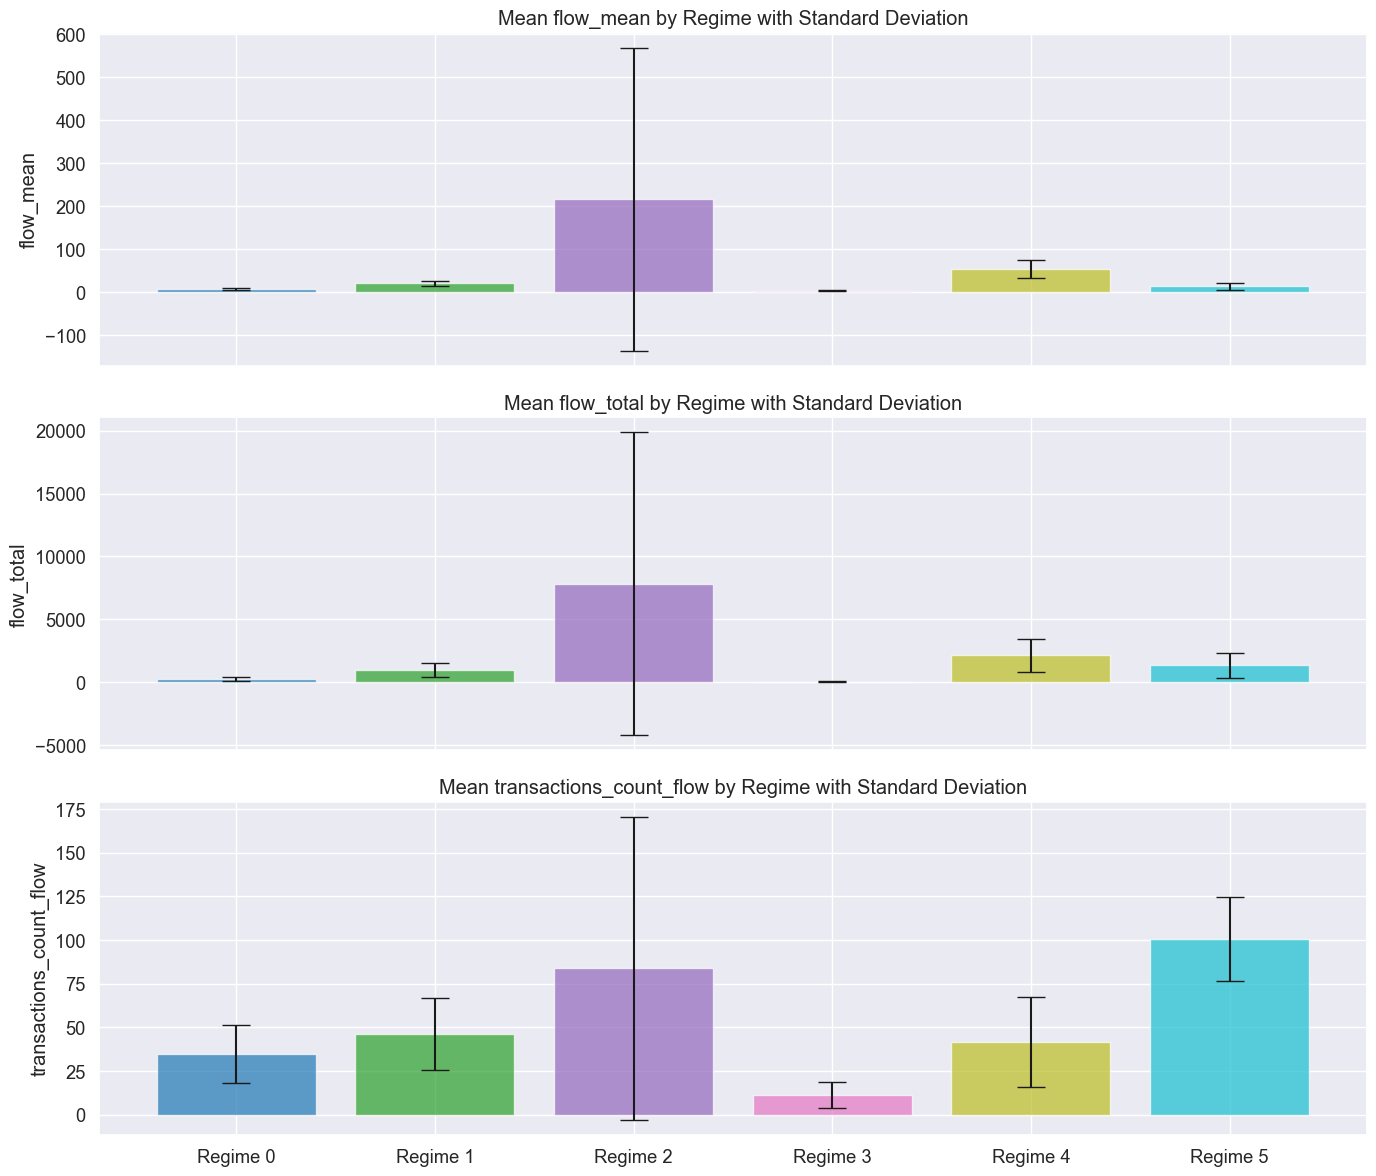

In [20]:
# Cell 16: Plot regime characteristics
# Plot regime characteristics
fig, axes = plt.subplots(len(features), 1, figsize=(14, 4*len(features)), sharex=True)

# Handle case where there's only one feature
if len(features) == 1:
    axes = [axes]

for i, feature in enumerate(features):
    means = [regime_stats.loc[state, (feature, 'mean')] for state in range(optimal_n_states)]
    stds = [regime_stats.loc[state, (feature, 'std')] for state in range(optimal_n_states)]
    
    axes[i].bar(range(optimal_n_states), means, yerr=stds, capsize=10, 
              color=colors, alpha=0.7)
    axes[i].set_title(f'Mean {feature} by Regime with Standard Deviation')
    axes[i].set_ylabel(feature)
    axes[i].set_xticks(range(optimal_n_states))
    axes[i].set_xticklabels([f'Regime {state}' for state in range(optimal_n_states)])
    axes[i].grid(True, axis='y')

plt.tight_layout()
plt.show()


Regime transition counts:
To       0     1    2     3     4     5
From                                   
0.0   7312  2710  349  4235  1884  2012
1.0   3003  2206  137  1609  1153  1130
2.0    276   174  153   152   242   177
3.0   3813  1481  214  2980  1245  1075
4.0   1910  1291  183  1174  1655   767
5.0   2188  1376  138   659   801  1320


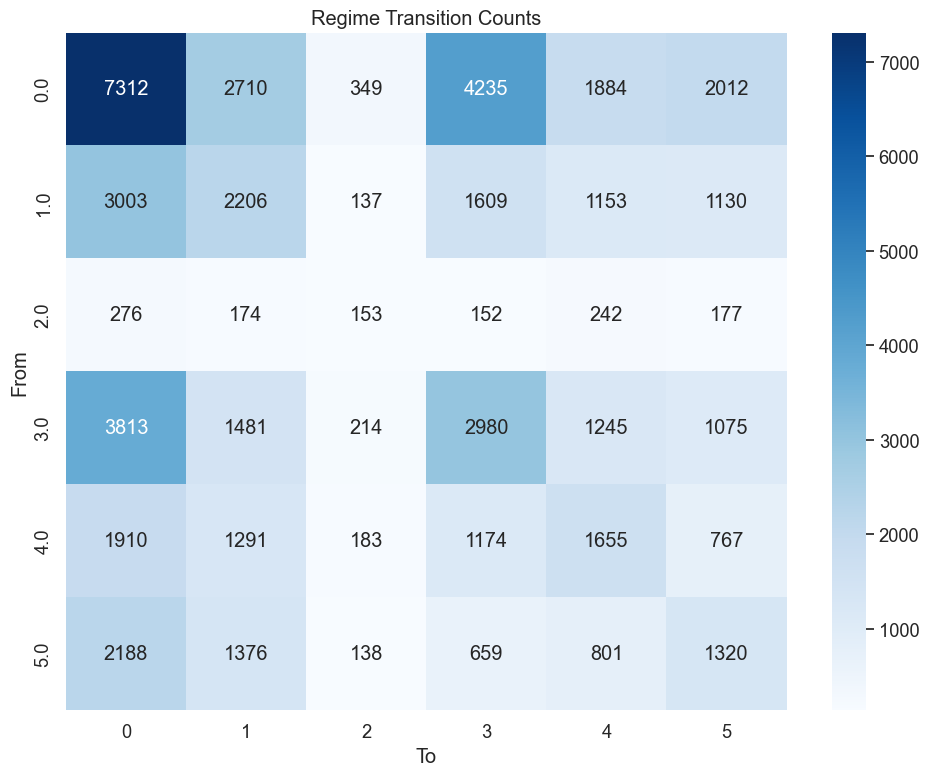

In [21]:
# Cell 17: Analyze regime transitions
# Analyze regime transitions
transitions = pd.crosstab(df['regime'].shift(1), df['regime'], 
                         rownames=['From'], colnames=['To'])
print("\nRegime transition counts:")
print(transitions)

plt.figure(figsize=(10, 8))
sns.heatmap(transitions, annot=True, cmap='Blues', fmt='d')
plt.title('Regime Transition Counts')
plt.tight_layout()
plt.show()


Regime transition probabilities:
To           0         1         2         3         4         5
From                                                            
0.0   0.395201  0.146471  0.018863  0.228894  0.101827  0.108745
1.0   0.325070  0.238796  0.014830  0.174172  0.124811  0.122321
2.0   0.235094  0.148211  0.130324  0.129472  0.206133  0.150767
3.0   0.352794  0.137028  0.019800  0.275722  0.115192  0.099463
4.0   0.273639  0.184957  0.026218  0.168195  0.237106  0.109885
5.0   0.337550  0.212280  0.021290  0.101666  0.123573  0.203641


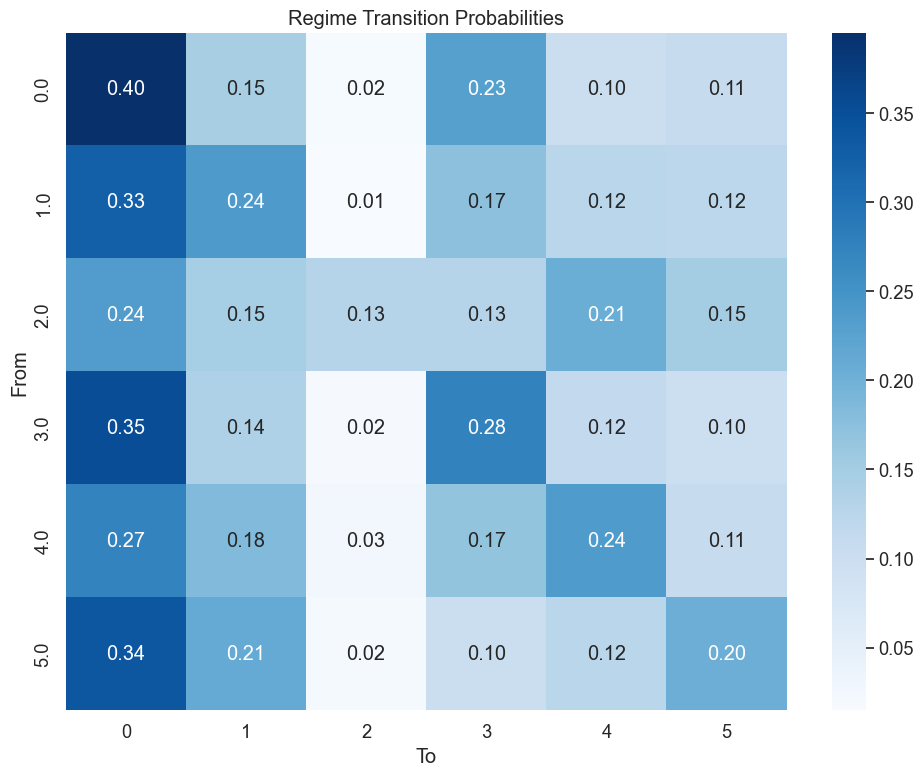

In [22]:
# Cell 18: Calculate transition probabilities
# Calculate transition probabilities
transition_probs = transitions.div(transitions.sum(axis=1), axis=0)
print("\nRegime transition probabilities:")
print(transition_probs)

plt.figure(figsize=(10, 8))
sns.heatmap(transition_probs, annot=True, cmap='Blues', fmt='.2f')
plt.title('Regime Transition Probabilities')
plt.tight_layout()
plt.show()

In [23]:
# Cell 19: Analyze regime durations
# Analyze regime durations
regime_changes = df['regime'].diff().fillna(0) != 0
regime_start_indices = df.index[regime_changes].tolist()
regime_start_indices.append(df.index[-1])  # Add the last index

durations = []
regimes = []
start_dates = []
end_dates = []

for i in range(len(regime_start_indices)-1):
    start_idx = regime_start_indices[i]
    end_idx = regime_start_indices[i+1]
    
    regime = df.loc[start_idx, 'regime']
    start_date = df.loc[start_idx, 'datetime']
    end_date = df.loc[end_idx-1, 'datetime'] if end_idx > 0 else df.loc[end_idx, 'datetime']
    
    # Calculate duration in days
    try:
        duration = (end_date - start_date).total_seconds() / (60*60*24)  # Duration in days
    except TypeError:
        # If still getting TypeError, force conversion to datetime
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        duration = (end_date - start_date).total_seconds() / (60*60*24)
    
    regimes.append(regime)
    start_dates.append(start_date)
    end_dates.append(end_date)
    durations.append(duration)

duration_df = pd.DataFrame({
    'regime': regimes,
    'start_date': start_dates,
    'end_date': end_dates,
    'duration_days': durations
})

print("\nRegime duration statistics:")
print(duration_df.groupby('regime')['duration_days'].agg(['count', 'mean', 'min', 'max']))



Regime duration statistics:
        count      mean       min       max
regime                                     
0       11190  0.003907  0.000000  0.138831
1        7032  0.002299  0.000000  0.075336
2        1021  0.001535  0.000000  0.109155
3        7829  0.000810 -0.000799  0.036181
4        5325  0.002234  0.000000  0.081076
5        5161  0.003751  0.000000  0.086782


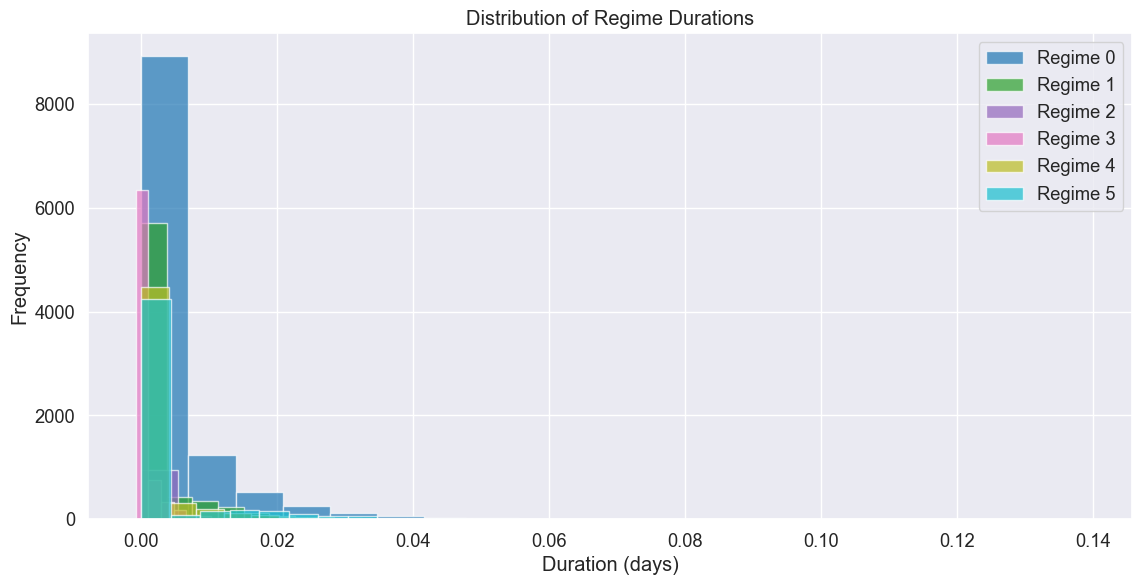

In [24]:
# Cell 20: Plot regime durations
# Plot regime durations
plt.figure(figsize=(12, 6))
for state in range(optimal_n_states):
    state_durations = duration_df[duration_df['regime'] == state]['duration_days']
    if len(state_durations) > 0:
        plt.hist(state_durations, alpha=0.7, label=f'Regime {state}', 
                bins=20, color=colors[state])

plt.title('Distribution of Regime Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Cell 21: Train/test split for validation
# Train/test split for validation
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
dates_train, dates_test = df['datetime'][:train_size], df['datetime'][train_size:]

# Train HMM on training data
train_model = hmm.GaussianHMM(n_components=optimal_n_states, 
                            covariance_type='full', 
                            n_iter=100, 
                            random_state=42)
train_model.fit(X_train)

# Predict regimes for both training and test data
train_regimes = train_model.predict(X_train)
test_regimes = train_model.predict(X_test)

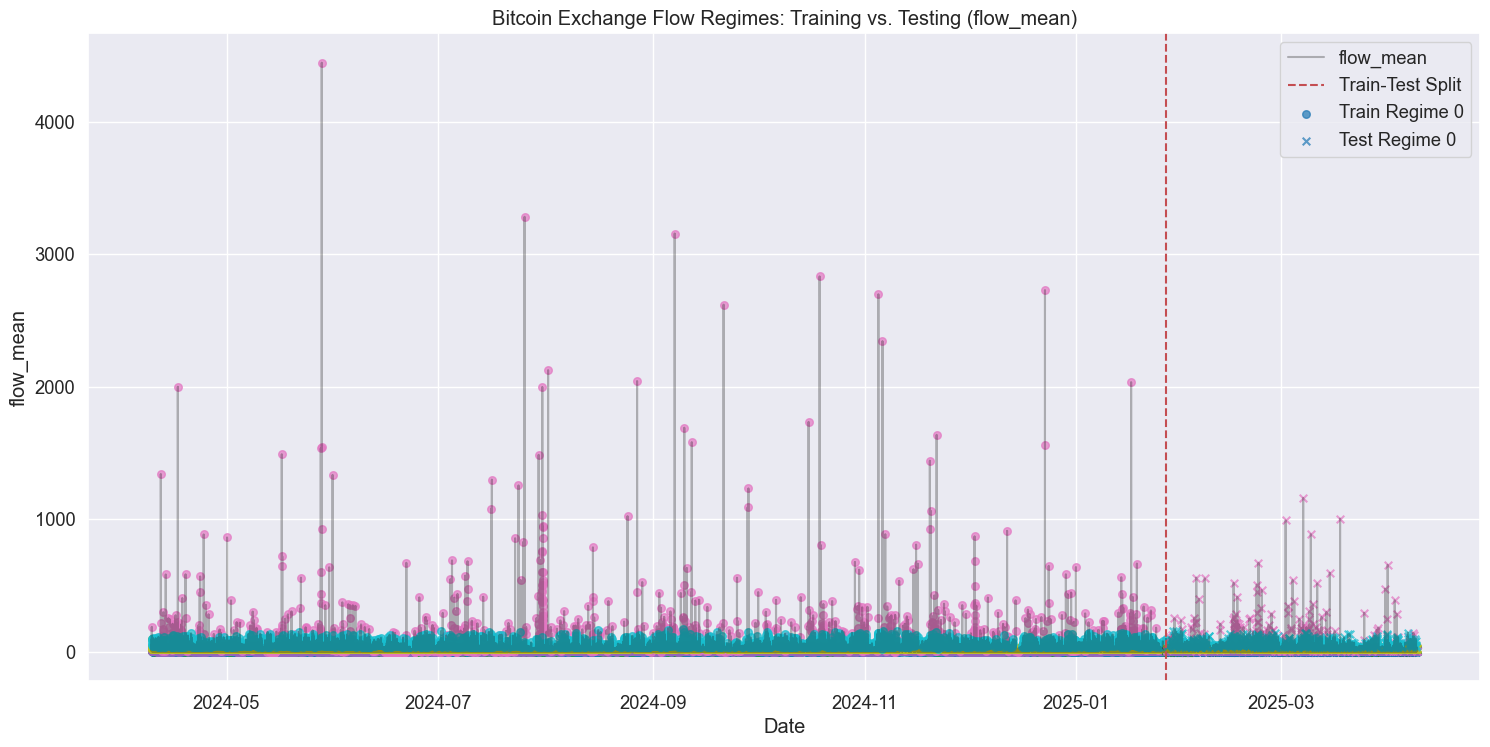

In [26]:
# Cell 22: Visualize training and test regimes
# Visualize training and test regimes
plt.figure(figsize=(16, 8))

# Plot true data
plt.plot(df['datetime'], df[features[0]], 'k-', alpha=0.3, label=features[0])

# Mark training and testing periods
plt.axvline(x=dates_train.iloc[-1], color='r', linestyle='--', 
           label='Train-Test Split')

# Plot regimes for training data
for state in range(optimal_n_states):
    mask = (train_regimes == state)
    if np.any(mask):
        plt.scatter(dates_train.iloc[mask], 
                   df[features[0]].iloc[:train_size][mask], 
                   c=[colors[state]], 
                   label=f'Train Regime {state}' if state == 0 else None,
                   alpha=0.7,
                   s=30)

# Plot regimes for test data
for state in range(optimal_n_states):
    mask = (test_regimes == state)
    if np.any(mask):
        plt.scatter(dates_test.iloc[mask], 
                   df[features[0]].iloc[train_size:][mask], 
                   c=[colors[state]], 
                   marker='x',
                   label=f'Test Regime {state}' if state == 0 else None,
                   alpha=0.7,
                   s=30)

plt.title(f'Bitcoin Exchange Flow Regimes: Training vs. Testing ({features[0]})')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Cell 23: Define functions for prediction and simulation
def predict_next_regime(model, current_observation):
    # Get the current state
    current_state = model.predict(current_observation.reshape(1, -1))[0]
    
    # Get transition probabilities from the current state
    transition_probs = model.transmat_[current_state]
    
    # Get the most likely next state
    next_state = np.argmax(transition_probs)
    
    # Return the predicted next state and its probability
    return next_state, transition_probs[next_state]

# Function to simulate future regime sequences
def simulate_future_regimes(model, current_observation, n_steps=30):
    # Initialize with the current observation
    observation = current_observation.copy()
    states = []
    observations = []
    
    # Create a random state for reproducibility
    random_state = np.random.RandomState(42)
    
    for _ in range(n_steps):
        # Predict the next state based on the current observation
        state = model.predict(observation.reshape(1, -1))[0]
        states.append(state)
        
        # Get the parameters for this state
        means = model.means_[state]
        covars = model.covars_[state]
        
        # Generate a sample from a multivariate normal distribution for this state
        next_obs = random_state.multivariate_normal(means, covars)
        observations.append(next_obs)
        
        # Update the current observation for the next iteration
        observation = next_obs
    
    return states, np.array(observations)


In [28]:
# Cell 24: Predict next regime
# Predict next regime
last_observation = X_scaled[-1]
next_regime, next_prob = predict_next_regime(model, last_observation)

print(f"\nCurrent regime: {hidden_states[-1]}")
print(f"Predicted next regime: {next_regime} with probability {next_prob:.4f}")


Current regime: 3
Predicted next regime: 0 with probability 0.3313


In [29]:
# Cell 25: Simulate future regimes
# Simulate future regimes
n_future_steps = 30  # Predict 30 steps ahead
future_regimes, future_observations = simulate_future_regimes(model, last_observation, n_future_steps)

# Create future dates
last_date = df['datetime'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_future_steps)

# Create a dataframe for future predictions
future_df = pd.DataFrame({
    'datetime': future_dates,
    'regime': future_regimes
})

# Inverse transform the observations to get the original scale
future_observations_orig = scaler.inverse_transform(future_observations)
for i, feature in enumerate(features):
    future_df[feature] = future_observations_orig[:, i]


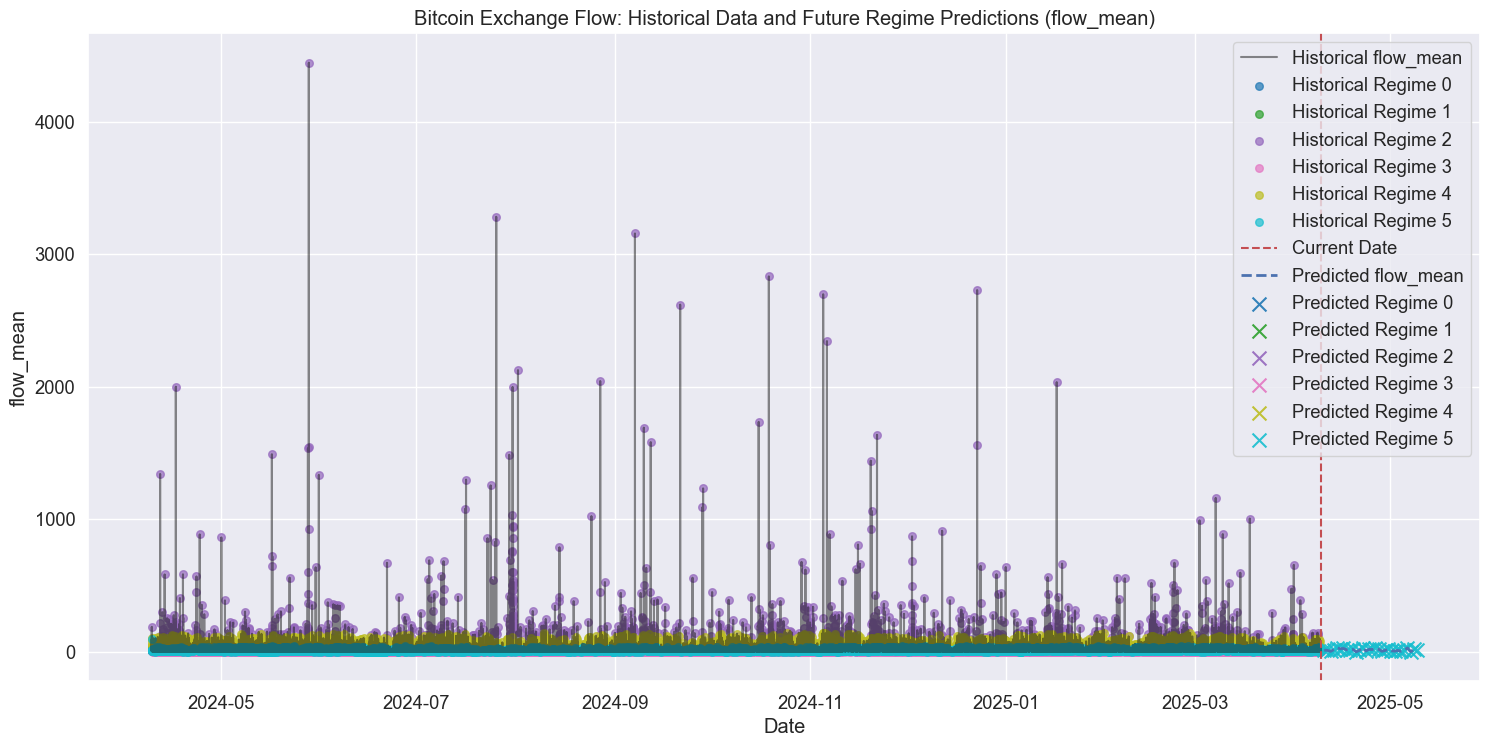

In [30]:
# Cell 26: Visualize predictions
# Visualize predictions
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df['datetime'], df[features[0]], 'k-', alpha=0.5, label=f'Historical {features[0]}')

# Plot historical regimes
for state in range(optimal_n_states):
    mask = (df['regime'] == state)
    plt.scatter(df.loc[mask, 'datetime'], 
               df.loc[mask, features[0]], 
               c=[colors[state]], 
               label=f'Historical Regime {state}',
               alpha=0.7,
               s=30)

# Mark the current date
plt.axvline(x=last_date, color='r', linestyle='--', label='Current Date')

# Plot future predictions
plt.plot(future_df['datetime'], future_df[features[0]], 'b--', linewidth=2, label=f'Predicted {features[0]}')

# Plot future regimes
for state in range(optimal_n_states):
    mask = (future_df['regime'] == state)
    plt.scatter(future_df.loc[mask, 'datetime'], 
               future_df.loc[mask, features[0]], 
               c=[colors[state]], 
               marker='x',
               label=f'Predicted Regime {state}',
               alpha=0.9,
               s=100)

plt.title(f'Bitcoin Exchange Flow: Historical Data and Future Regime Predictions ({features[0]})')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Cell 27: Calculate regime characteristics and interpretations
# Calculate regime characteristics and interpretations
print("\nRegime interpretations:")
for state in range(optimal_n_states):
    print(f"\nRegime {state}:")
    
    # Flow characteristics
    feature_means = [regime_stats.loc[state, (feature, 'mean')] for feature in features]
    feature_stds = [regime_stats.loc[state, (feature, 'std')] for feature in features]
    
    for i, feature in enumerate(features):
        mean_val = feature_means[i]
        std_val = feature_stds[i]
        
        # Determine relative level compared to other regimes
        all_means = [regime_stats.loc[s, (feature, 'mean')] for s in range(optimal_n_states)]
        median_mean = np.median(all_means)
        level = "High" if mean_val > median_mean else "Low"
        
        print(f"- {level} {feature}: {mean_val:.2f} (±{std_val:.2f})")
    
    # Stability information
    if state in transition_probs.index and state in transition_probs.columns:
        stability = transition_probs.loc[state, state]
        stability_level = "High" if stability > 0.7 else "Moderate" if stability > 0.4 else "Low"
        print(f"- {stability_level} stability (self-transition probability: {stability:.2f})")
    
    # Duration information
    state_durations = duration_df[duration_df['regime'] == state]['duration_days']
    if len(state_durations) > 0:
        avg_duration = state_durations.mean()
        print(f"- Average duration: {avg_duration:.2f} days")
    
    # Frequency
    frequency = (df['regime'] == state).mean() * 100
    print(f"- Frequency: {frequency:.2f}% of the time")


Regime interpretations:

Regime 0:
- Low flow_mean: 7.29 (±3.08)
- Low flow_total: 236.68 (±135.72)
- Low transactions_count_flow: 34.72 (±16.51)
- Low stability (self-transition probability: 0.40)
- Average duration: 0.00 days
- Frequency: 34.79% of the time

Regime 1:
- High flow_mean: 20.49 (±6.01)
- Low flow_total: 964.99 (±557.14)
- High transactions_count_flow: 46.30 (±20.56)
- Low stability (self-transition probability: 0.24)
- Average duration: 0.00 days
- Frequency: 17.37% of the time

Regime 2:
- High flow_mean: 216.06 (±352.27)
- High flow_total: 7829.76 (±12045.37)
- High transactions_count_flow: 83.80 (±86.75)
- Low stability (self-transition probability: 0.13)
- Average duration: 0.00 days
- Frequency: 2.21% of the time

Regime 3:
- Low flow_mean: 2.87 (±1.71)
- Low flow_total: 34.97 (±27.66)
- Low transactions_count_flow: 11.12 (±7.33)
- Low stability (self-transition probability: 0.28)
- Average duration: 0.00 days
- Frequency: 20.32% of the time

Regime 4:
- High flow

In [32]:
# Cell 28: Save the model
# Create a dictionary with all the necessary components
model_package = {
    'model': model,
    'scaler': scaler,
    'optimal_n_states': optimal_n_states,
    'features': features,
    'train_test_split': train_size,
    'creation_date': datetime.now().strftime('%Y-%m-%d')
}

# Save to disk
try:
    with open('btc_exchange_flow_hmm_model_local.pkl', 'wb') as f:
        pickle.dump(model_package, f)
    print("\nModel successfully saved to 'btc_exchange_flow_hmm_model_local.pkl'")
except Exception as e:
    print(f"\nError saving model: {e}")

print("\nHMM analysis complete!")


Model successfully saved to 'btc_exchange_flow_hmm_model_local.pkl'

HMM analysis complete!


In [33]:
# Cell 29: Define functions for regime mapping and accuracy evaluation
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment

# Function to map regimes between two sets based on feature similarities
def map_regimes(df_true, true_regimes, df_pred, pred_regimes, features):
    """
    Maps regime labels from predicted regimes to true regimes based on feature similarities.
    
    Args:
        df_true: DataFrame with true data
        true_regimes: Array of true regime labels
        df_pred: DataFrame with prediction data
        pred_regimes: Array of predicted regime labels
        features: List of feature columns to use for comparison
        
    Returns:
        Dictionary mapping predicted regime labels to true regime labels
    """
    # Calculate mean feature values for each regime
    true_regime_means = {}
    pred_regime_means = {}
    
    # Add regime columns to the DataFrames
    df_true = df_true.copy()
    df_true['regime'] = true_regimes
    
    df_pred = df_pred.copy()
    df_pred['regime'] = pred_regimes
    
    # Calculate means for each regime
    for regime in np.unique(true_regimes):
        true_regime_means[regime] = df_true[df_true['regime'] == regime][features].mean().values
        
    for regime in np.unique(pred_regimes):
        pred_regime_means[regime] = df_pred[df_pred['regime'] == regime][features].mean().values
    
    # Create cost matrix for assignment problem
    # We want to minimize the distance between true and predicted regime means
    true_regimes_unique = sorted(true_regime_means.keys())
    pred_regimes_unique = sorted(pred_regime_means.keys())
    
    cost_matrix = np.zeros((len(true_regimes_unique), len(pred_regimes_unique)))
    
    for i, true_reg in enumerate(true_regimes_unique):
        for j, pred_reg in enumerate(pred_regimes_unique):
            # Calculate Euclidean distance between feature means
            distance = np.linalg.norm(true_regime_means[true_reg] - pred_regime_means[pred_reg])
            cost_matrix[i, j] = distance
    
    # Use the Hungarian algorithm to find optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create mapping dictionary
    mapping = {}
    for i, j in zip(col_ind, row_ind):  # Note the reversed order here
        mapping[pred_regimes_unique[i]] = true_regimes_unique[j]
        
    return mapping

# Function to remap regimes using the mapping
def remap_regimes(regimes, mapping):
    """
    Remaps regime labels based on the provided mapping.
    
    Args:
        regimes: Array of regime labels to remap
        mapping: Dictionary mapping old labels to new labels
        
    Returns:
        Array of remapped regime labels
    """
    remapped = np.array([mapping.get(r, r) for r in regimes])
    return remapped

# Function to calculate accuracy with proper regime alignment
def aligned_regime_accuracy(true_regimes, pred_regimes, df_true, df_pred, features):
    """
    Calculates accuracy after aligning regime labels.
    
    Args:
        true_regimes: Array of true regime labels
        pred_regimes: Array of predicted regime labels
        df_true: DataFrame with true data
        df_pred: DataFrame with prediction data
        features: List of feature columns to use for comparison
        
    Returns:
        Accuracy score, mapping dictionary, and remapped predicted regimes
    """
    # Map regimes
    mapping = map_regimes(df_true, true_regimes, df_pred, pred_regimes, features)
    
    # Remap predicted regimes
    remapped_pred = remap_regimes(pred_regimes, mapping)
    
    # Calculate accuracy
    accuracy = np.mean(true_regimes == remapped_pred)
    
    return accuracy, mapping, remapped_pred

In [34]:
# Cell 30: Calculate aligned regime accuracy
# Calculate aligned accuracy on training data
train_aligned_accuracy, train_mapping, train_remapped = aligned_regime_accuracy(
    hidden_states[:train_size], 
    train_regimes, 
    df.iloc[:train_size], 
    df.iloc[:train_size], 
    features
)

print(f"Training regime mapping: {train_mapping}")
print(f"Aligned training regime prediction accuracy: {train_aligned_accuracy:.4f}")

# Calculate aligned accuracy on test data
test_aligned_accuracy, test_mapping, test_remapped = aligned_regime_accuracy(
    hidden_states[train_size:], 
    test_regimes, 
    df.iloc[train_size:], 
    df.iloc[train_size:], 
    features
)

print(f"Test regime mapping: {test_mapping}")
print(f"Aligned test regime prediction accuracy: {test_aligned_accuracy:.4f}")


Training regime mapping: {np.int64(2): np.int64(0), np.int64(1): np.int64(1), np.int64(3): np.int64(2), np.int64(0): np.int64(3), np.int64(5): np.int64(4), np.int64(4): np.int64(5)}
Aligned training regime prediction accuracy: 0.6998
Test regime mapping: {np.int64(2): np.int64(0), np.int64(1): np.int64(1), np.int64(3): np.int64(2), np.int64(0): np.int64(3), np.int64(5): np.int64(4), np.int64(4): np.int64(5)}
Aligned test regime prediction accuracy: 0.6491


In [35]:
# Cell 31: Calculate cluster evaluation metrics
# For training data
train_ari = adjusted_rand_score(hidden_states[:train_size], train_regimes)
train_nmi = normalized_mutual_info_score(hidden_states[:train_size], train_regimes)
train_ami = adjusted_mutual_info_score(hidden_states[:train_size], train_regimes)

print("Training data cluster evaluation metrics:")
print(f"Adjusted Rand Index: {train_ari:.4f}")
print(f"Normalized Mutual Information: {train_nmi:.4f}")
print(f"Adjusted Mutual Information: {train_ami:.4f}")

# For test data
test_ari = adjusted_rand_score(hidden_states[train_size:], test_regimes)
test_nmi = normalized_mutual_info_score(hidden_states[train_size:], test_regimes)
test_ami = adjusted_mutual_info_score(hidden_states[train_size:], test_regimes)

print("\nTest data cluster evaluation metrics:")
print(f"Adjusted Rand Index: {test_ari:.4f}")
print(f"Normalized Mutual Information: {test_nmi:.4f}")
print(f"Adjusted Mutual Information: {test_ami:.4f}")

Training data cluster evaluation metrics:
Adjusted Rand Index: 0.6272
Normalized Mutual Information: 0.6759
Adjusted Mutual Information: 0.6758

Test data cluster evaluation metrics:
Adjusted Rand Index: 0.5156
Normalized Mutual Information: 0.6354
Adjusted Mutual Information: 0.6351


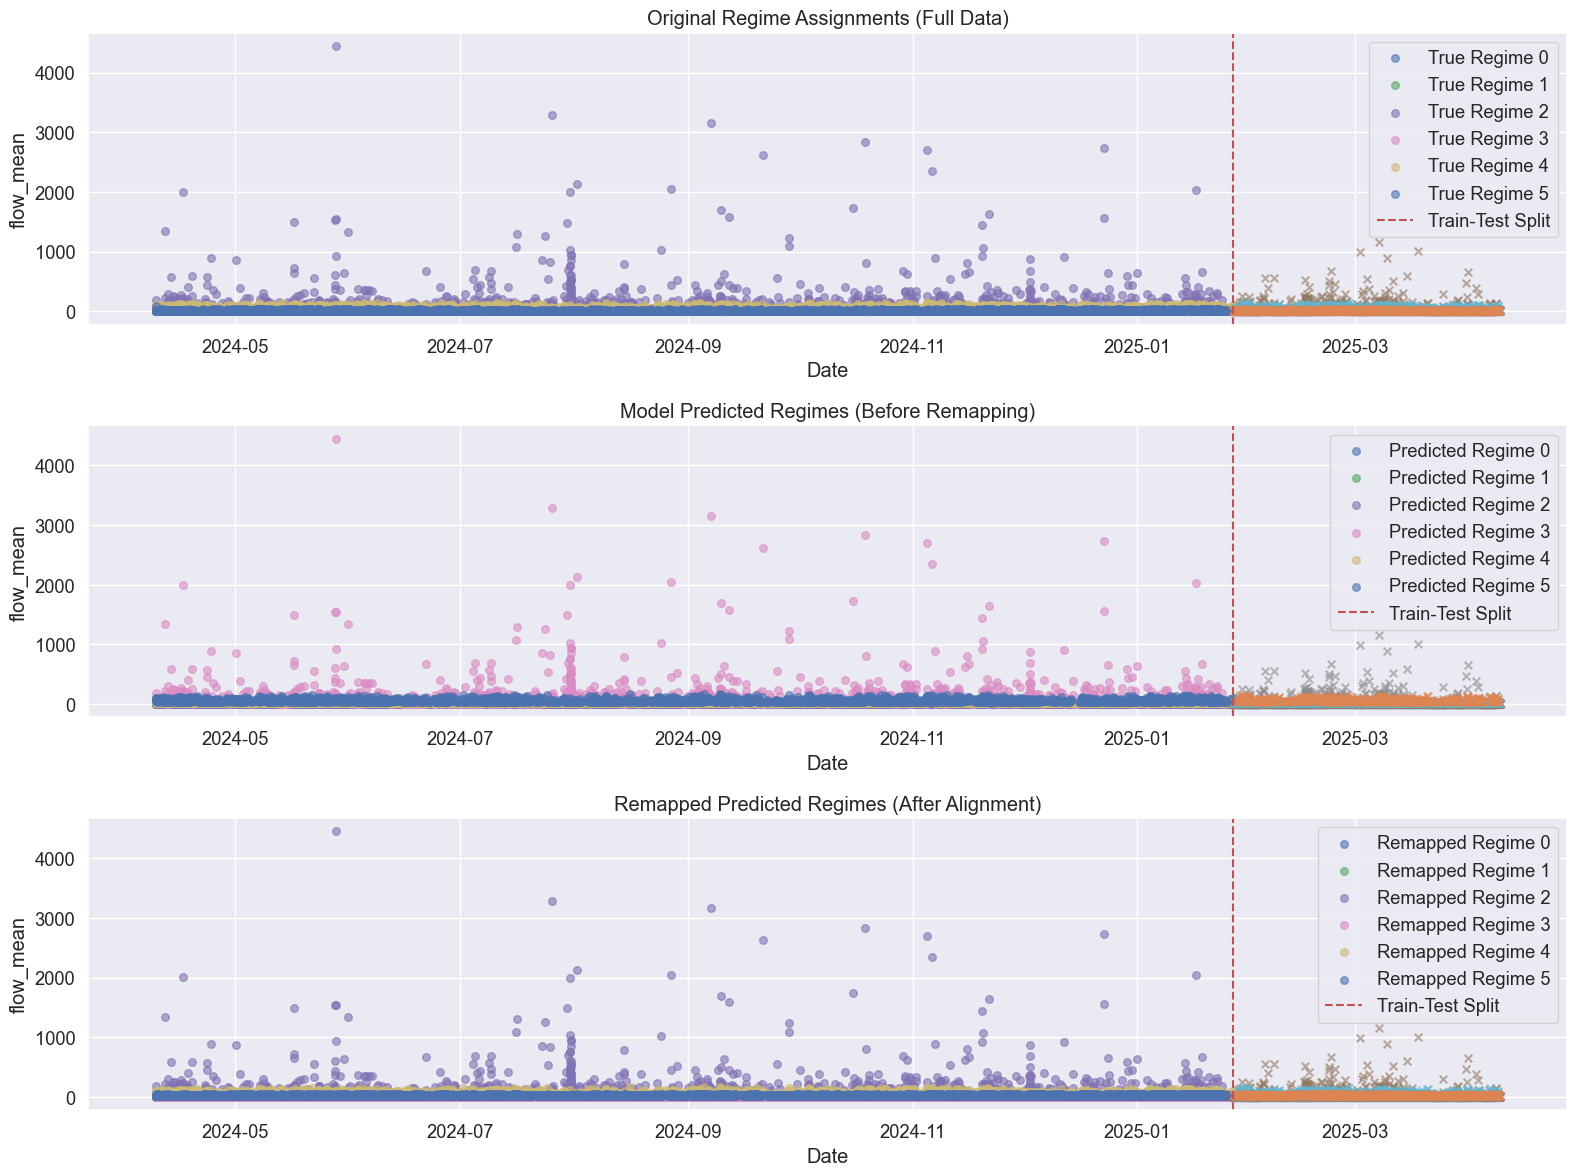

In [36]:
# Cell 32: Visualize original, predicted, and remapped regimes
plt.figure(figsize=(16, 12))

# Top subplot: Original regime assignments
plt.subplot(3, 1, 1)
for state in range(optimal_n_states):
    # Original training regimes
    mask_train = (hidden_states[:train_size] == state)
    if np.any(mask_train):
        plt.scatter(df.iloc[:train_size].loc[mask_train, 'datetime'], 
                    df.iloc[:train_size].loc[mask_train, features[0]], 
                    s=30, alpha=0.6, label=f'True Regime {state}')
    
    # Original test regimes
    mask_test = (hidden_states[train_size:] == state)
    if np.any(mask_test):
        plt.scatter(df.iloc[train_size:].loc[mask_test, 'datetime'], 
                    df.iloc[train_size:].loc[mask_test, features[0]], 
                    s=30, alpha=0.6, marker='x')

plt.axvline(x=df.iloc[train_size-1]['datetime'], color='r', linestyle='--', label='Train-Test Split')
plt.title('Original Regime Assignments (Full Data)')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)

# Middle subplot: Model's predicted regimes (before remapping)
plt.subplot(3, 1, 2)
for state in range(optimal_n_states):
    # Training predictions
    mask_train = (train_regimes == state)
    if np.any(mask_train):
        plt.scatter(df.iloc[:train_size].loc[mask_train, 'datetime'], 
                    df.iloc[:train_size].loc[mask_train, features[0]], 
                    s=30, alpha=0.6, label=f'Predicted Regime {state}')
    
    # Test predictions
    mask_test = (test_regimes == state)
    if np.any(mask_test):
        plt.scatter(df.iloc[train_size:].loc[mask_test, 'datetime'], 
                    df.iloc[train_size:].loc[mask_test, features[0]], 
                    s=30, alpha=0.6, marker='x')

plt.axvline(x=df.iloc[train_size-1]['datetime'], color='r', linestyle='--', label='Train-Test Split')
plt.title('Model Predicted Regimes (Before Remapping)')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)

# Bottom subplot: Remapped predicted regimes
plt.subplot(3, 1, 3)
for state in range(optimal_n_states):
    # Training remapped
    mask_train = (train_remapped == state)
    if np.any(mask_train):
        plt.scatter(df.iloc[:train_size].loc[mask_train, 'datetime'], 
                    df.iloc[:train_size].loc[mask_train, features[0]], 
                    s=30, alpha=0.6, label=f'Remapped Regime {state}')
    
    # Test remapped
    mask_test = (test_remapped == state)
    if np.any(mask_test):
        plt.scatter(df.iloc[train_size:].loc[mask_test, 'datetime'], 
                    df.iloc[train_size:].loc[mask_test, features[0]], 
                    s=30, alpha=0.6, marker='x')

plt.axvline(x=df.iloc[train_size-1]['datetime'], color='r', linestyle='--', label='Train-Test Split')
plt.title('Remapped Predicted Regimes (After Alignment)')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
# Cell 33: Analyze transition detection accuracy
def identify_transitions(regimes):
    """Returns indices where regime transitions occur"""
    changes = np.diff(regimes) != 0
    change_indices = np.where(changes)[0] + 1  # +1 because diff reduces length by 1
    return change_indices

# Get transition points
true_train_transitions = identify_transitions(hidden_states[:train_size])
pred_train_transitions = identify_transitions(train_remapped)

true_test_transitions = identify_transitions(hidden_states[train_size:])
pred_test_transitions = identify_transitions(test_remapped)

# Function to calculate transition detection accuracy
def transition_detection_accuracy(true_transitions, pred_transitions, tolerance=5):
    """
    Calculate how accurately transition points are detected within a tolerance.
    
    Args:
        true_transitions: Indices of true transitions
        pred_transitions: Indices of predicted transitions
        tolerance: Number of time steps to consider as correct detection
        
    Returns:
        Precision, recall, and F1 score
    """
    # Initialize counters
    true_positives = 0
    
    # Count matches
    for true_idx in true_transitions:
        # Check if any predicted transition is within tolerance
        if any(abs(true_idx - pred_idx) <= tolerance for pred_idx in pred_transitions):
            true_positives += 1
    
    # Calculate metrics
    precision = true_positives / len(pred_transitions) if len(pred_transitions) > 0 else 0
    recall = true_positives / len(true_transitions) if len(true_transitions) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Calculate transition detection metrics
train_prec, train_rec, train_f1 = transition_detection_accuracy(true_train_transitions, pred_train_transitions)
test_prec, test_rec, test_f1 = transition_detection_accuracy(true_test_transitions, pred_test_transitions)

print("Regime Transition Detection (Training Data):")
print(f"Precision: {train_prec:.4f} (% of predicted transitions that are correct)")
print(f"Recall: {train_rec:.4f} (% of actual transitions that were detected)")
print(f"F1 Score: {train_f1:.4f} (harmonic mean of precision and recall)")

print("\nRegime Transition Detection (Test Data):")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_rec:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Regime Transition Detection (Training Data):
Precision: 0.9869 (% of predicted transitions that are correct)
Recall: 0.9999 (% of actual transitions that were detected)
F1 Score: 0.9934 (harmonic mean of precision and recall)

Regime Transition Detection (Test Data):
Precision: 1.0112
Recall: 1.0000
F1 Score: 1.0056


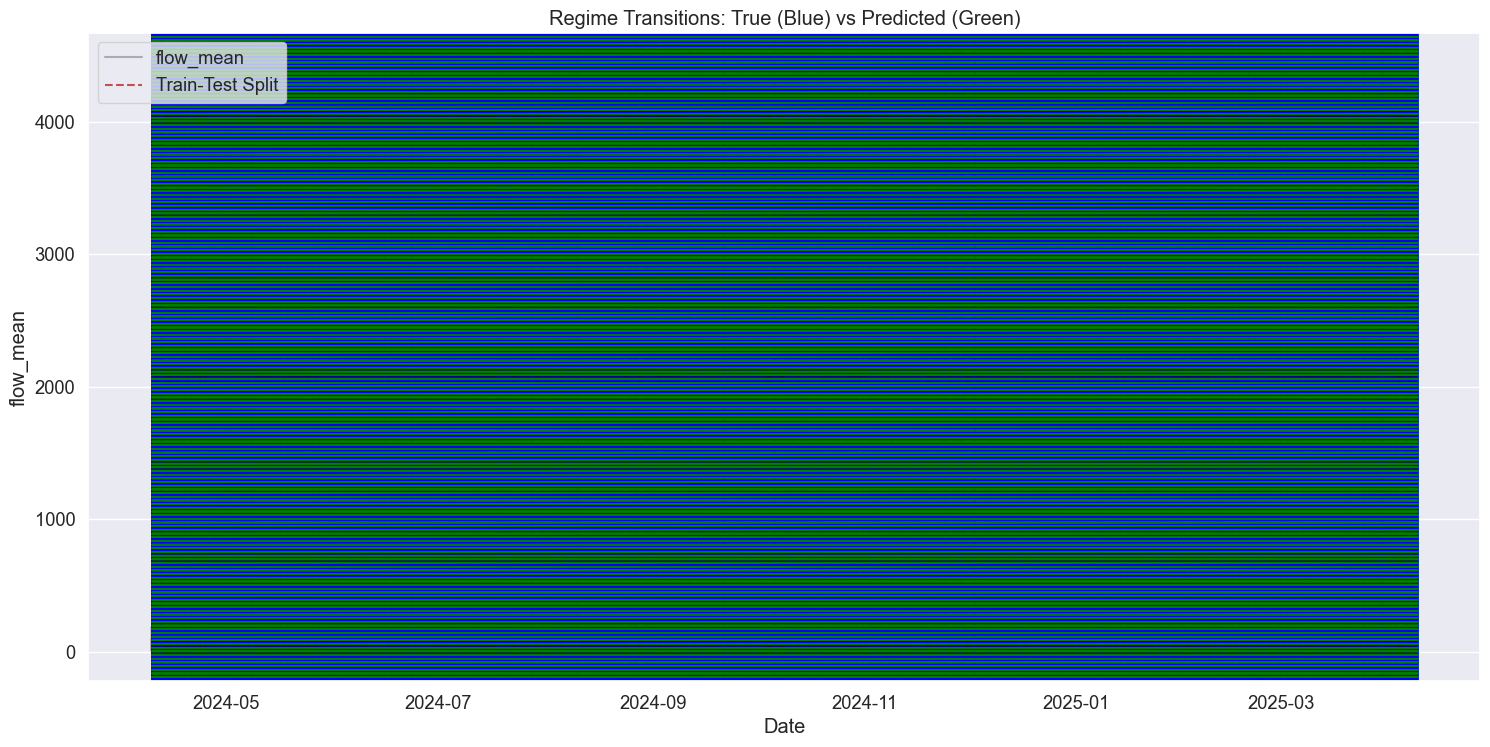

In [38]:
# Cell 34: Visualize regime transitions
# Visualize the transitions
plt.figure(figsize=(16, 8))
plt.plot(df['datetime'], df[features[0]], 'k-', alpha=0.3, label=features[0])

# Mark the train-test split
plt.axvline(x=df.iloc[train_size-1]['datetime'], color='r', linestyle='--', 
           label='Train-Test Split')

# Mark true transitions
for idx in true_train_transitions:
    plt.axvline(x=df.iloc[idx]['datetime'], color='blue', alpha=0.5, linewidth=1)
for idx in true_test_transitions:
    plt.axvline(x=df.iloc[train_size + idx]['datetime'], color='blue', alpha=0.5, linewidth=1)

# Mark predicted transitions
for idx in pred_train_transitions:
    plt.axvline(x=df.iloc[idx]['datetime'], color='green', alpha=0.5, linewidth=1, linestyle=':')
for idx in pred_test_transitions:
    plt.axvline(x=df.iloc[train_size + idx]['datetime'], color='green', alpha=0.5, linewidth=1, linestyle=':')

plt.title('Regime Transitions: True (Blue) vs Predicted (Green)')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.grid(True)
plt.legend()
plt.show()